Deep Neural Networks with TensorFlow

- based on https://www.kaggle.com/kakauandme/digit-recognizer/tensorflow-deep-nn 
- extended and achieved **0.99157** score
- added documentations to tensorflow built-in functions

In [1]:
# import packages

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from subprocess import check_output

# Learning rate for learning algorithm
LEARNING_RATE = 5e-4

# number of training iterations
TRAINING_ITERATIONS = 10000
ITERATIONS_PER_RUN = 100

# dropout. Dropout is an extremely effective and simple regularization technique
# based on keeping a neuron active with some probability p (a hyperparameter, here is DROPOUT), 
# or setting it to zero otherwise.
# More about dropout http://cs231n.github.io/neural-networks-2/ 
DROPOUT = 0.5
# training is made by selecting batches of size 50
BATCH_SIZE = 100

# validation set size. Validation set is a set of examples used to tune the parameters .
# set to 0 to train on all available data
VALIDATION_SIZE = 2000

# image number to output
IMAGE_TO_DISPLAY = 25

In [2]:
# Strutified shuffle is used insted of simple shuffle in order to achieve sample balancing
    # or equal number of examples in each of 10 classes.
# Since there are different number of examples for each 10 classes in the MNIST data you may
    # also use simple shuffle.

def stratified_shuffle(labels, num_classes):
    ix = np.argsort(labels).reshape((num_classes,-1))
    for i in range(len(ix)):
        np.random.shuffle(ix[i])
    return ix.T.reshape((-1))

In [3]:
# preload train and test data
dataset = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv").values

images = dataset.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)
print('data size: (%g, %g)' % images.shape)

# size of one image - 784 values which can be transformed to 28 by 28 image
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square (28x28)
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

data size: (42000, 784)
image_size => 784
image_width => 28
image_height => 28


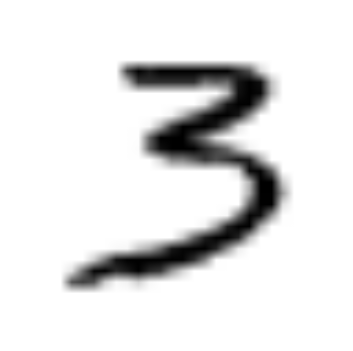

In [4]:
# display an image
def display(img):
    
    # (784) => (28x28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# display an image. IMAGE_TO_DISPLAY = 25
display(images[IMAGE_TO_DISPLAY])

In [5]:
# print information about image size, label of image-to-display and number of labels
labels_flat = dataset[[0]].values.ravel()
print('length of one image ({0})'.format(len(labels_flat)))
print ('label of image [{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_count = np.unique(labels_flat).shape[0]
print('number of labes => {0}'.format(labels_count))

length of one image (42000)
label of image [25] => 3
number of labes => 10


In [6]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels vector for image [{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels vector for image [25] => [0 0 0 1 0 0 0 0 0 0]


In [7]:
# split data into training & validation sets
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]
train_labels_flat = labels_flat[VALIDATION_SIZE:]

#train_images = images
#train_labels = labels
#train_labels_flat = labels_flat

print('train data size({0[0]},{0[1]})'.format(train_images.shape))
print('validation data size({0[0]},{0[1]})'.format(validation_images.shape))

train data size(40000,784)
validation data size(2000,784)


In [8]:
# weights initialization.
# tf.truncated_normal: Outputs random values from a truncated normal distribution.
# The generated values follow a normal distribution with specified standard deviation.

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# tf.constant: Creates a constant tensor. 
# The resulting tensor is populated with values of type dtype, as specified by arguments value and shape
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [9]:
# convolution
# Computes a 2-D convolution given 4-D input and filter tensors.
# tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, data_format=None, name=None)
# input: A Tensor. Must be one of the following types: half, float32, float64.
# filter: A Tensor. Must have the same type as input.
# strides: A list of ints. 1-D of length 4. The stride of the sliding window for each dimension 
            # of input. Must be in the same order as the dimension specified with format.
# padding: A string from: "SAME", "VALID". The type of padding algorithm to use.

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [10]:
# Performs the max pooling on the input.
# tf.nn.max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)
# value: A 4-D Tensor with shape [batch, height, width, channels] and type tf.float32.
# ksize: A list of ints that has length >= 4. The size of the window for each dimension 
        # of the input tensor.
# strides: A list of ints that has length >= 4. The stride of the sliding window for 
            # each dimension of the input tensor.
# padding: A string, either 'VALID' or 'SAME'. 

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [11]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

In [12]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)]
# tf.reshape(tensor, shape, name=None)
# Given tensor, this operation returns a tensor that has the same values as tensor with shape shape.
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)

h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  
# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

In [13]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  
# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))
layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

In [14]:
# fully-connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

#tf.matmul(a, b, transpose_a=False, transpose_b=False, a_is_sparse=False, b_is_sparse=False, name=None)
# Multiplies matrix a by matrix b, producing a * b.
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

In [15]:
# dropout
# tf.nn.dropout(x, keep_prob, noise_shape=None, seed=None, name=None)
# Computes dropout.
# With probability keep_prob, outputs the input element scaled up by 1 / keep_prob, otherwise outputs 0. 
    # The scaling is so that the expected sum is unchanged.
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [16]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

In [17]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# optimisation function
global_step = tf.Variable(0, name='global_step', trainable=False)
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy, global_step=global_step)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [18]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)
print(predict)

Tensor("ArgMax_2:0", shape=(?,), dtype=int64)


In [19]:
# Training
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=100

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global train_labels_flat
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        #perm = np.arange(num_examples)
        #np.random.shuffle(perm)
        perm = stratified_shuffle(train_labels_flat, 10)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        train_labels_flat = train_labels_flat[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [20]:
# displays the progress of the training
# Training accuracy, validation accuracy and iterations

def check_progress(sess, accuracy, batch_xs, batch_ys, i):
    import datetime
    train_accuracy = accuracy.eval(session=sess, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 1.0})       
    if(VALIDATION_SIZE):
        validation_accuracy = accuracy.eval(session=sess, feed_dict={x: validation_images,
                                                                     y_: validation_labels,
                                                                     keep_prob: 1.0})                                  
        print('%s: trn / val => %.4f / %.4f for step %d'
              % (str(datetime.datetime.now()), train_accuracy, validation_accuracy, i+1))
    else:
        print('training_accuracy => %.4f for step %d' % (train_accuracy, i+1))
        validation_accuracy = []
    return (train_accuracy, validation_accuracy)

In [21]:
# In this part we save model after a certain number of iterations and use the saved model
# for the next round
# By this we achieve 10 epochs on the entire training data (validation data included)

saver = tf.train.Saver(max_to_keep=5)
sess = tf.Session()
sess.run(tf.initialize_all_variables())

ckpt = tf.train.get_checkpoint_state('.')
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Restored session from: %s" % ckpt.model_checkpoint_path)
else:
    print("No checkpoint found.")

start_step = global_step.eval(sess)
for i in range(start_step, min(start_step + ITERATIONS_PER_RUN, TRAINING_ITERATIONS)):
    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)

    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

    # check progress and create a checkpoint
    if (i+1) % display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        train_accuracy, validation_accuracy = check_progress(sess, accuracy, batch_xs, batch_ys, i)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        x_range.append(i)

        saver.save(sess, 'model', global_step=i+1)

        # increase display_step
        #if i % (display_step*10) == 0 and i:
        #    display_step *= 2

No checkpoint found.
2016-10-28 15:59:57.635304: trn / val => 0.9100 / 0.9410 for step 100


In [22]:
#ckpt = tf.train.get_checkpoint_state('.')
#ckpt.model_checkpoint_path
#saver.restore(sess, './model-3800')

validation_accuracy => 0.9410


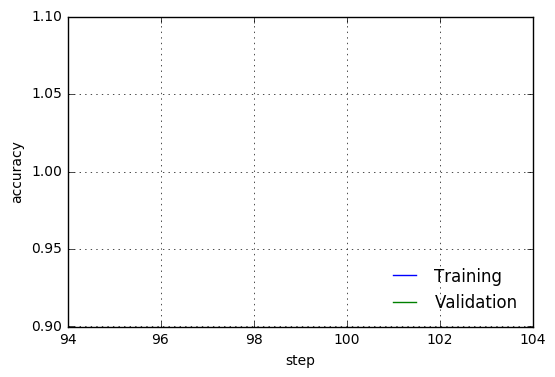

In [23]:
# check final accuracy on validation set.
# Since we may use validation data set in training data set the accuracy is around 0.99

if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(session=sess, feed_dict={x: validation_images,
                                                                 y_: validation_labels,
                                                                 keep_prob: 1.0})
    print('validation_accuracy => %.4f' % validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.9)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.grid()
    plt.show()

test_images(28000,784)
predicted_lables(28000)
predicted_lables[25] => 4.0
saved: submission_softmax_100.csv


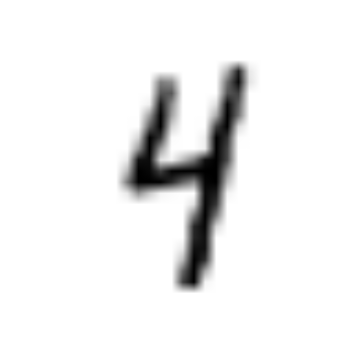

In [24]:
# read test data from CSV file 
test_images = pd.read_csv('../input/test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)
print('test_images({0[0]},{0[1]})'.format(test_images.shape))

# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(
        session=sess, feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE],
                                 keep_prob: 1.0})

print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
file_name = 'submission_softmax_%s.csv' % global_step.eval(sess)
np.savetxt(file_name, 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')
print('saved: %s' % file_name)

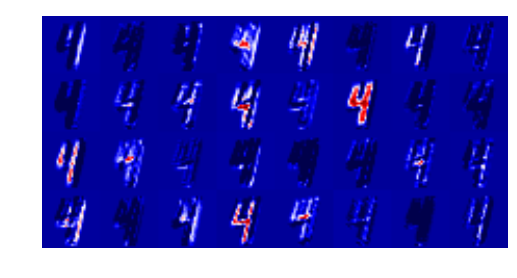

In [25]:
layer1_grid = layer1.eval(session=sess, feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], 
                                                   keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )

In [26]:
sess.close()

In [27]:
#!rm model-6*
!ls -ahl

total 39M
drwxr-xr-x 2 root root 4.0K Oct 28 16:00 .
drwxr-xr-x 5 root root 4.0K Oct 28 15:58 ..
-rw-r--r-- 1 root root  26K Oct 28 15:58 __notebook_source__.ipynb
-rw-r--r-- 1 root root  551 Oct 28 15:58 __output__.json
-rw-r--r-- 1 root root 311K Oct 28 15:58 __results__.html
-rw-r--r-- 1 root root   75 Oct 28 15:59 checkpoint
-rw-r--r-- 1 root root    0 Oct 28 15:58 custom.css
-rw-r--r-- 1 root root  38M Oct 28 15:59 model-100
-rw-r--r-- 1 root root  71K Oct 28 15:59 model-100.meta
-rw-r--r-- 1 root root 208K Oct 28 16:00 submission_softmax_100.csv


In [28]:
#!cp model-8200 model-submission-8200
#!cp model-8200.meta model-submission-8200.meta
#!cat submission_softmax_8200.csv